In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from collections import defaultdict
from statistics import stdev, mean
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [2]:
# download 2023 Nasdaq-100 daily closing prices
url = 'https://en.m.wikipedia.org/wiki/Nasdaq-100'
df_nasdaq_100_list = pd.read_html(url, attrs={'id': "constituents"}, index_col='Symbol')[0]
tickers = list(df_nasdaq_100_list.index)
df_nasdaq_100 = yf.download(tickers, '2023-01-01', '2023-12-31')
df_nasdaq_100.head()

[*********************100%***********************]  101 of 101 completed


Price                       Adj Close                                     \
Ticker                           AAPL       ABNB        ADBE         ADI   
Date                                                                       
2023-01-03 00:00:00+00:00  123.768471  84.900002  336.920013  156.755066   
2023-01-04 00:00:00+00:00  125.045029  88.720001  341.410004  160.093796   
2023-01-05 00:00:00+00:00  123.718971  87.709999  328.440002  154.091812   
2023-01-06 00:00:00+00:00  128.271118  88.519997  332.750000  159.717453   
2023-01-09 00:00:00+00:00  128.795593  89.239998  341.980011  161.242050   

Price                                                                     \
Ticker                            ADP        ADSK        AEP        AMAT   
Date                                                                       
2023-01-03 00:00:00+00:00  227.386276  185.149994  87.589432   95.099075   
2023-01-04 00:00:00+00:00  228.457840  187.960007  88.189545   97.635551   
2023-01-05 00:00:00+00:00  223.530518  182.070007  86.583084   96.269012   
2023-01-06 00:00:00+00:00  229.778214  187.190002  89.122040  102.511932   
2023-01-09 00:00:00+00:00  229.156296  192.470001  90.433067  104.694511   

Price                                             ...     Volume           \
Ticker                           AMD        AMGN  ...       TSLA      TTD   
Date                                              ...                       
2023-01-03 00:00:00+00:00  64.019997  247.431000  ...  231402800  2855600   
2023-01-04 00:00:00+00:00  64.660004  250.022141  ...  180389000  4653700   
2023-01-05 00:00:00+00:00  62.330002  252.357880  ...  157986300  3908000   
2023-01-06 00:00:00+00:00  63.959999  260.244659  ...  220911100  3976700   
2023-01-09 00:00:00+00:00  67.239998  255.440735  ...  190284000  4005300   

Price                                                                    \
Ticker                        TTWO      TXN     VRSK     VRTX       WBD   
Date                                                                      
2023-01-03 00:00:00+00:00  1668600  4294100   644400  1100400  25186100   
2023-01-04 00:00:00+00:00  1474800  6285300   603200  1137400  34435900   
2023-01-05 00:00:00+00:00  1218400  6876800   693300  1187000  33761600   
2023-01-06 00:00:00+00:00  2602800  6725900   728700   943400  29842600   
2023-01-09 00:00:00+00:00  2185800  5733900  1095800  1299200  25383800   

Price                                                 
Ticker                        WDAY      XEL       ZS  
Date                                                  
2023-01-03 00:00:00+00:00  2094000  2684500  2510900  
2023-01-04 00:00:00+00:00  1660200  2265900  1617000  
2023-01-05 00:00:00+00:00  3003800  2104500  3931100  
2023-01-06 00:00:00+00:00  1910300  2976200  2613100  
2023-01-09 00:00:00+00:00  1727600  2707800  2961300  

[5 rows x 606 columns]

In [3]:
# 250 trading days
df_nasdaq_100.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2023-01-03 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Columns: 606 entries, ('Adj Close', 'AAPL') to ('Volume', 'ZS')
dtypes: float64(506), int64(100)
memory usage: 1.2 MB


In [4]:
# convert to log returns
# 249 trading days
df_logr = np.log(df_nasdaq_100['Adj Close']).diff()[1:]
df_logr.head()

Ticker,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TSLA,TTD,TTWO,TXN,VRSK,VRTX,WBD,WDAY,XEL,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04 00:00:00+00:00,0.010261,0.044011,0.013239,0.021075,0.004701,0.015063,0.006828,0.026322,0.009947,0.010418,...,0.049979,0.006566,0.034881,0.035866,0.016276,0.002828,0.084387,0.010982,0.008527,0.012625
2023-01-05 00:00:00+00:00,-0.010661,-0.011449,-0.038730,-0.038211,-0.021804,-0.031838,-0.018384,-0.014095,-0.036700,0.009299,...,-0.029469,-0.039591,-0.007615,-0.013330,-0.014586,0.003689,0.045205,-0.066589,-0.020443,-0.066698
2023-01-06 00:00:00+00:00,0.036134,0.009193,0.013037,0.035858,0.027567,0.027733,0.028902,0.062833,0.025815,0.030774,...,0.024352,-0.007069,-0.011485,0.048126,0.029071,0.008026,0.041485,0.005913,0.029177,-0.004128
2023-01-09 00:00:00+00:00,0.004080,0.008101,0.027361,0.009500,-0.002710,0.027816,0.014603,0.021067,0.050010,-0.018632,...,0.057655,0.039412,0.003336,0.008640,-0.004549,-0.024345,0.025296,0.011047,0.009632,0.007570
2023-01-10 00:00:00+00:00,0.004447,-0.007875,-0.009637,0.012607,0.005288,0.004975,-0.006864,0.014451,0.011974,0.013824,...,-0.007711,0.019138,0.004083,0.009688,0.008151,0.019302,0.078650,-0.016835,0.001804,0.002098


In [5]:
risk_free_annual_return = 1.05
risk_free_daily_log_return = np.log(risk_free_annual_return**(1/len(df_logr)))
df_logr.insert(len(df_logr.columns), 'RISKFREE', [risk_free_daily_log_return] * len(df_logr))
df_logr.head()

/tmp/ipykernel_3094501/3378395148.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_logr.insert(len(df_logr.columns), 'RISKFREE', [risk_free_daily_log_return] * len(df_logr))


Ticker,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TTD,TTWO,TXN,VRSK,VRTX,WBD,WDAY,XEL,ZS,RISKFREE
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04 00:00:00+00:00,0.010261,0.044011,0.013239,0.021075,0.004701,0.015063,0.006828,0.026322,0.009947,0.010418,...,0.006566,0.034881,0.035866,0.016276,0.002828,0.084387,0.010982,0.008527,0.012625,0.000196
2023-01-05 00:00:00+00:00,-0.010661,-0.011449,-0.038730,-0.038211,-0.021804,-0.031838,-0.018384,-0.014095,-0.036700,0.009299,...,-0.039591,-0.007615,-0.013330,-0.014586,0.003689,0.045205,-0.066589,-0.020443,-0.066698,0.000196
2023-01-06 00:00:00+00:00,0.036134,0.009193,0.013037,0.035858,0.027567,0.027733,0.028902,0.062833,0.025815,0.030774,...,-0.007069,-0.011485,0.048126,0.029071,0.008026,0.041485,0.005913,0.029177,-0.004128,0.000196
2023-01-09 00:00:00+00:00,0.004080,0.008101,0.027361,0.009500,-0.002710,0.027816,0.014603,0.021067,0.050010,-0.018632,...,0.039412,0.003336,0.008640,-0.004549,-0.024345,0.025296,0.011047,0.009632,0.007570,0.000196
2023-01-10 00:00:00+00:00,0.004447,-0.007875,-0.009637,0.012607,0.005288,0.004975,-0.006864,0.014451,0.011974,0.013824,...,0.019138,0.004083,0.009688,0.008151,0.019302,0.078650,-0.016835,0.001804,0.002098,0.000196


In [6]:
tickers = list(df_logr.columns)

In [7]:
# regular returns
# 249 trading days
df_r = np.exp(df_logr)
df_r.head()

Ticker,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TTD,TTWO,TXN,VRSK,VRTX,WBD,WDAY,XEL,ZS,RISKFREE
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04 00:00:00+00:00,1.010314,1.044994,1.013327,1.021299,1.004713,1.015177,1.006851,1.026672,1.009997,1.010472,...,1.006588,1.035496,1.036517,1.016409,1.002832,1.088050,1.011042,1.008563,1.012705,1.000196
2023-01-05 00:00:00+00:00,0.989395,0.988616,0.962010,0.962510,0.978432,0.968664,0.981784,0.986004,0.963965,1.009342,...,0.961183,0.992414,0.986759,0.985520,1.003696,1.046243,0.935580,0.979765,0.935478,1.000196
2023-01-06 00:00:00+00:00,1.036794,1.009235,1.013123,1.036508,1.027950,1.028121,1.029324,1.064849,1.026151,1.031252,...,0.992956,0.988581,1.049302,1.029498,1.008059,1.042357,1.005930,1.029607,0.995881,1.000196
2023-01-09 00:00:00+00:00,1.004089,1.008134,1.027739,1.009546,0.997293,1.028207,1.014710,1.021291,1.051282,0.981541,...,1.040199,1.003341,1.008678,0.995462,0.975949,1.025618,1.011108,1.009679,1.007599,1.000196
2023-01-10 00:00:00+00:00,1.004456,0.992156,0.990409,1.012687,1.005303,1.004988,0.993160,1.014555,1.012046,1.013920,...,1.019323,1.004091,1.009735,1.008184,1.019489,1.081826,0.983306,1.001806,1.002100,1.000196


In [8]:
# makes a random unit vector of n-dimensions
def unit_random_simple(n):
    ws = np.random.random(n)
    return ws / np.sum(ws)

def unit_random_dirichlet(n, bias=1):
    return np.random.dirichlet(np.ones(n)*bias, size=1)[0]
    
def unit_random_angle_projection(n):
    ws = np.tan(np.random.rand(n) * np.pi/2) # unit cirlce projected out to x-axis
    return ws / np.sum(ws)

# makes a vector of n-dimensions, sets weight at positions set_weights, with values weight_values
def set_weights(n, indexes, weight_values):
    ws = np.zeros(n)
    for index, i in enumerate(indexes):
        ws[i] = weight_values[index]
    return ws

# make a random portfolio of length num_tickers, with all but portfolio_size tickers zeroed out
def random_portfolio_implementation(num_tickers, portfolio_size=2, fix_last=False):
    if fix_last is False:
        indexes = np.random.choice(np.arange(num_tickers), size=portfolio_size, replace=False)
    else:
        indexes = np.random.choice(np.arange(num_tickers-1), size=portfolio_size-1, replace=False)
        indexes = np.append(indexes, num_tickers-1)
    weight_values = unit_random(portfolio_size)
    portfolio_weights = list(set_weights(num_tickers, indexes, weight_values))
    check_sum = np.sum(portfolio_weights)
    if np.abs(1 - check_sum) > 0.01:
        print(indexes)
        print(weight_values)
        print(portfolio_weights)
        assert(False)
    return portfolio_weights

random_portfolio = lambda num_tickers, portfolio_size: random_portfolio_implementation(num_tickers, portfolio_size, fix_last=True)

# make many random_portfolios
def random_portfolios(num_tickers, portfolio_size=2, num_simulations=1_000):
    return [random_portfolio(num_tickers, portfolio_size) for _ in range(num_simulations)]

# given per ticker returns in ar for a trading window, compute and return the volatility and return for a portfolio in this trading window
def portfolio_return(ar, portfolio_weights):
    num_tickers = len(ar[0])
    portfolio_returns = []
    for day in range(len(ar)):
        daily_return = sum([portfolio_weights[i]*ar[day][i] for i in range(num_tickers)])
        if daily_return < 0.4:
            print(daily_return)
            print(portfolio_weights)
            print(ar[day])
            assert False
        portfolio_return = np.log(daily_return) # portfolio log return for given day
        portfolio_returns.append(portfolio_return)
    std = np.sqrt(np.var(portfolio_returns))
    avg = np.mean(portfolio_returns)
    return std, avg

# compute and return the volatility and return for many portfolios
def portfolio_returns(df, portfolios):
    ar = np.nan_to_num(df.to_numpy(), nan=1)
    xs, ys = [], []
    for i, portfolio in enumerate(portfolios):
        print(f'Computing return for portfolio {i+1:,} of {len(portfolios):,}      ', end='\r')
        std, avg = portfolio_return(ar, portfolio)
        xs.append(std)
        ys.append(avg)
    return xs, ys

# make num_simulations random portfolios, each with all portfolio_size tickers zeroes out, compute and return the volatily and return for each
def simulate_portfolios(df, portfolio_size=2, num_simulations=10_000):
    num_tickers = len(df.columns.values)
    ps = random_portfolios(num_tickers, portfolio_size, num_simulations)
    return portfolio_returns(df, ps)

In [9]:
def plot_portfolios(bare, portfolios, title, portfolio_point_size=6):
    # per-ticker log mean and variance
    xs, ys = bare
    # compute portfolios
    pxs, pys = portfolios
    # compute convex hull
    axs = xs + pxs
    ays = ys + pys
    points = np.array([[x, y] for x, y in zip(axs, ays)])
    hull = ConvexHull(points)
    # set up plot
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axhline(0, linestyle='--')
    plt.xlabel('log volatility')
    plt.ylabel('log return')
    plt.title(title)
    plt.xlim((0, 0.05))
    plt.ylim((-0.003, 0.006))
    # plot original points with labels
    ax.scatter(xs, ys)
    for i, ticker in enumerate(df_logr.columns.values):
        ax.annotate(ticker, (xs[i], ys[i]))
    # plot portfolio points
    ax.scatter(pxs, pys, zorder=0, s=portfolio_point_size)
    # save hull simplexes
    hxs = [points[simplex, 0] for simplex in hull.simplices]
    hys = [points[simplex, 1] for simplex in hull.simplices]
    # plot convex hull
    for x, y in zip(hxs, hys):
        plt.plot(x, y, 'r--')
    return hxs, hys

In [10]:
# compute per-ticker log mean and variance
xs = [np.sqrt(df_logr[ticker].var()) for ticker in df_logr.columns.values]
ys = [df_logr[ticker].mean() for ticker in df_logr.columns.values]
bare = xs, ys

In [11]:
hulls = defaultdict(lambda: defaultdict())

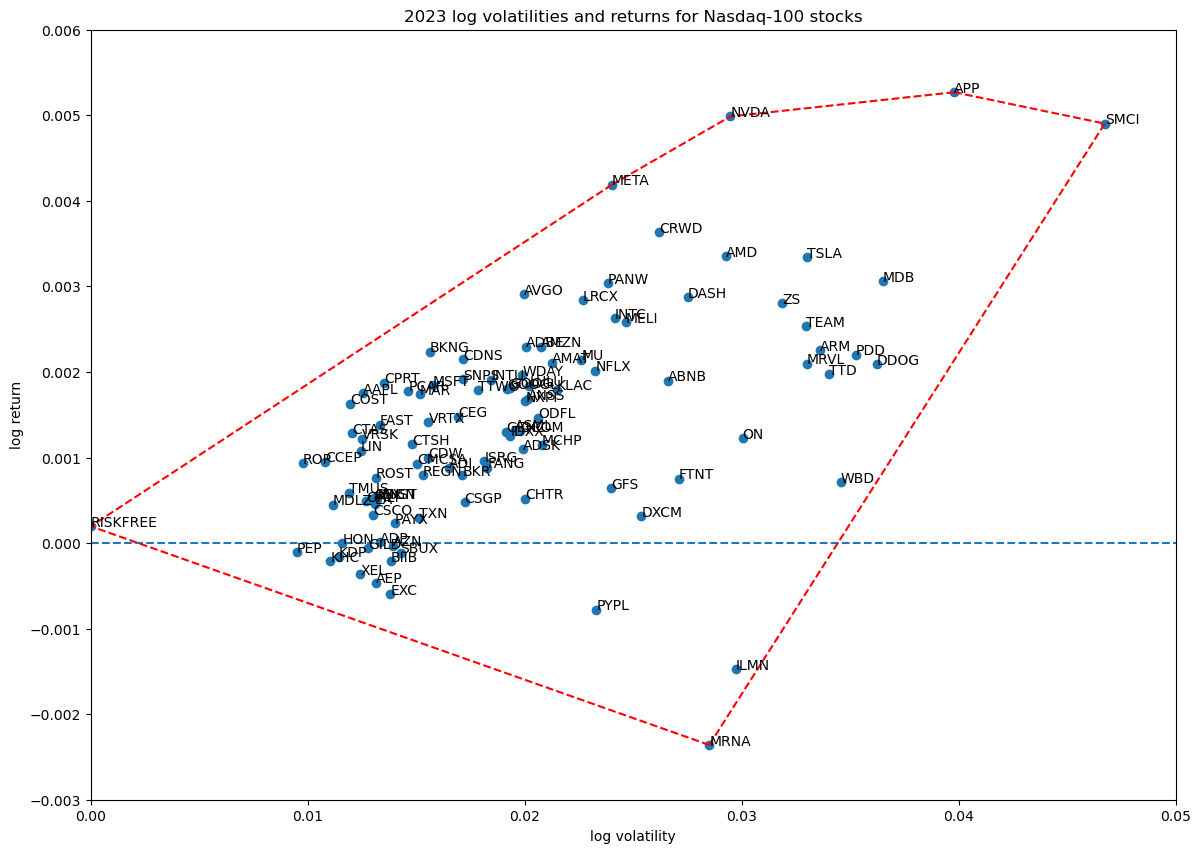

In [12]:
# calling simulate_portfolios() with num_simulations=0 just gets the bare stocks' volatilities and returns
portfolios = simulate_portfolios(df_r, portfolio_size=0, num_simulations=0)
hull_bare = plot_portfolios(bare, portfolios, '2023 log volatilities and returns for Nasdaq-100 stocks')

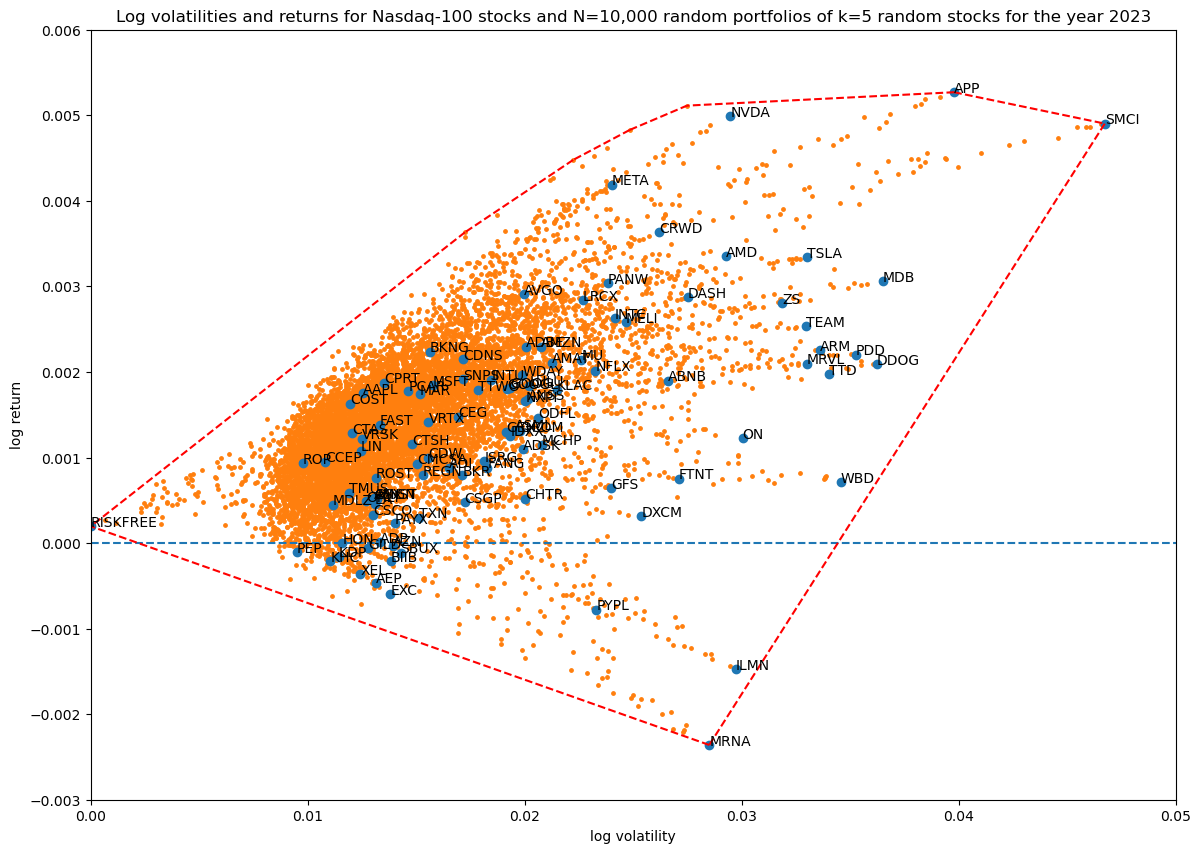

In [13]:
random_portfolio = lambda num_tickers, portfolio_size: random_portfolio_implementation(num_tickers, portfolio_size, fix_last=False)
unit_random = unit_random_angle_projection
num_simulations = 10_000
portfolio_size = 5
title = f'Log volatilities and returns for Nasdaq-100 stocks and N={num_simulations:,} random portfolios of k={portfolio_size} random stocks for the year 2023'
portfolios = simulate_portfolios(df_r, portfolio_size, num_simulations)
_ = plot_portfolios(bare, portfolios, title)

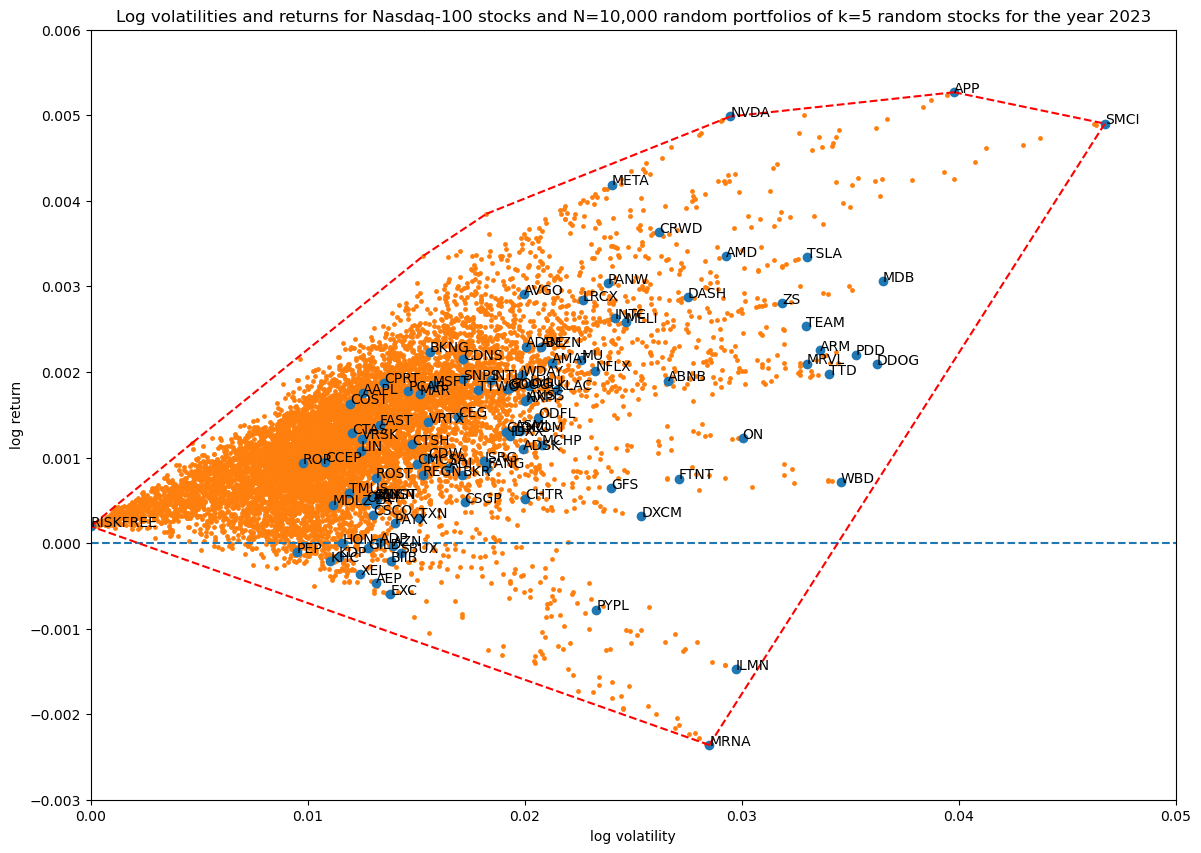

In [14]:
random_portfolio = lambda num_tickers, portfolio_size: random_portfolio_implementation(num_tickers, portfolio_size, fix_last=True)
unit_random = unit_random_angle_projection
num_simulations = 10_000
portfolio_size = 5
title = f'Log volatilities and returns for Nasdaq-100 stocks and N={num_simulations:,} random portfolios of k={portfolio_size} random stocks for the year 2023'
portfolios = simulate_portfolios(df_r, portfolio_size, num_simulations)
_ = plot_portfolios(bare, portfolios, title)

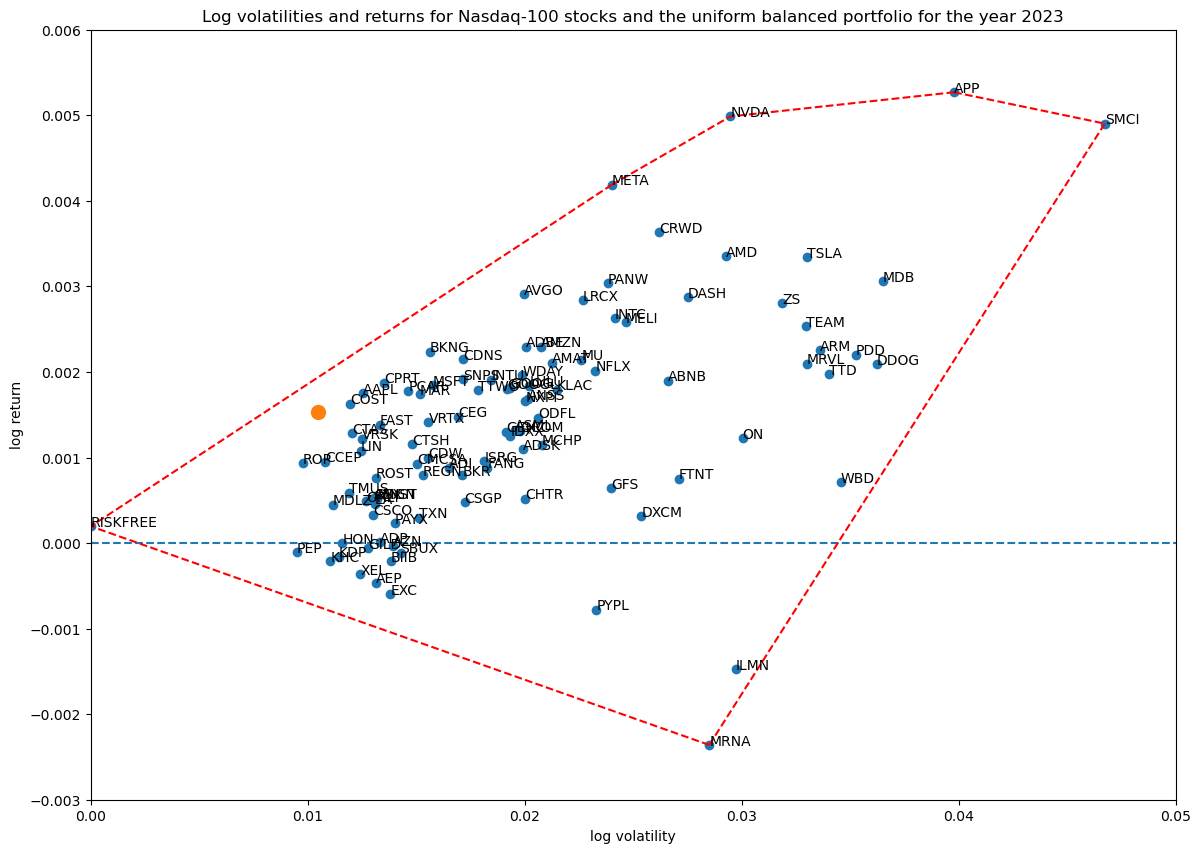

In [15]:
# This doesn't move much, since the risk-free asset only gets ~1% weight
title = f'Log volatilities and returns for Nasdaq-100 stocks and the uniform balanced portfolio for the year 2023'
portfolios = portfolio_returns(df_r, [np.ones(len(tickers))/len(tickers)])
_ = plot_portfolios(bare, portfolios, title, portfolio_point_size=100)

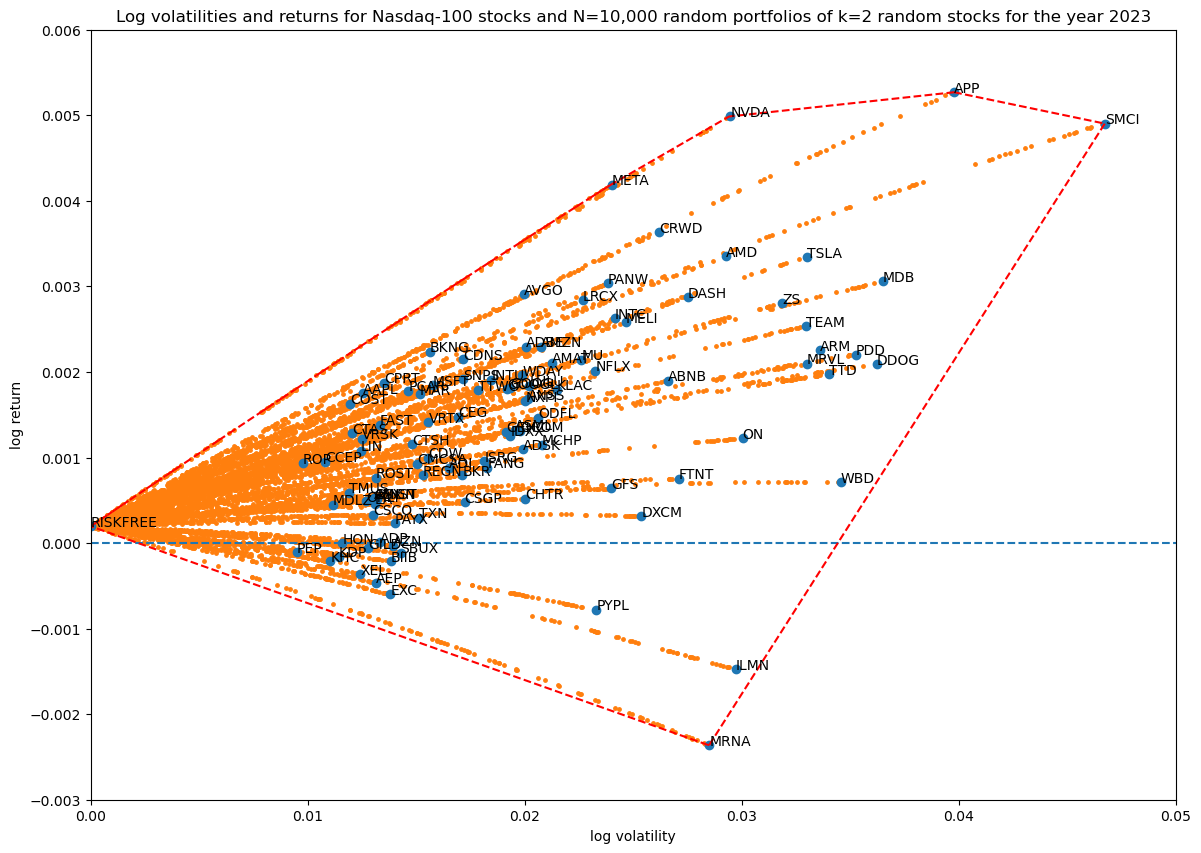

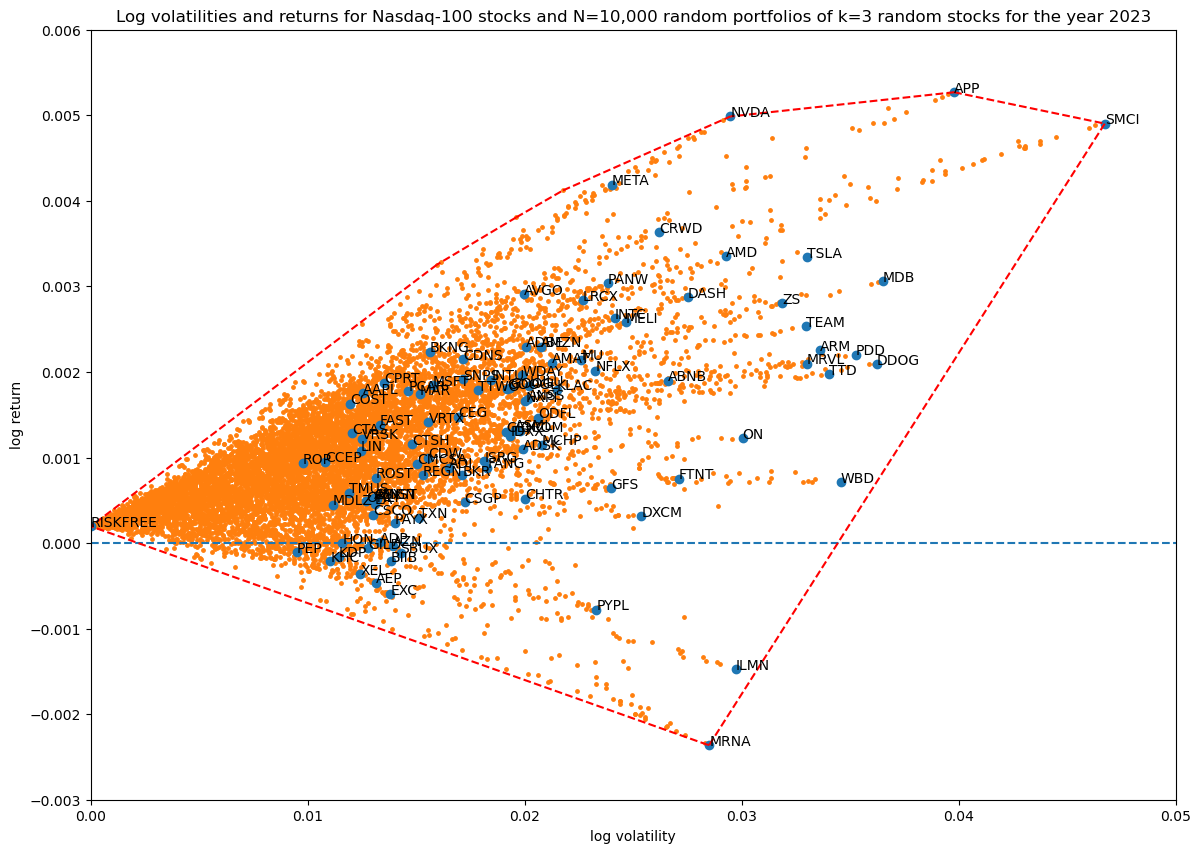

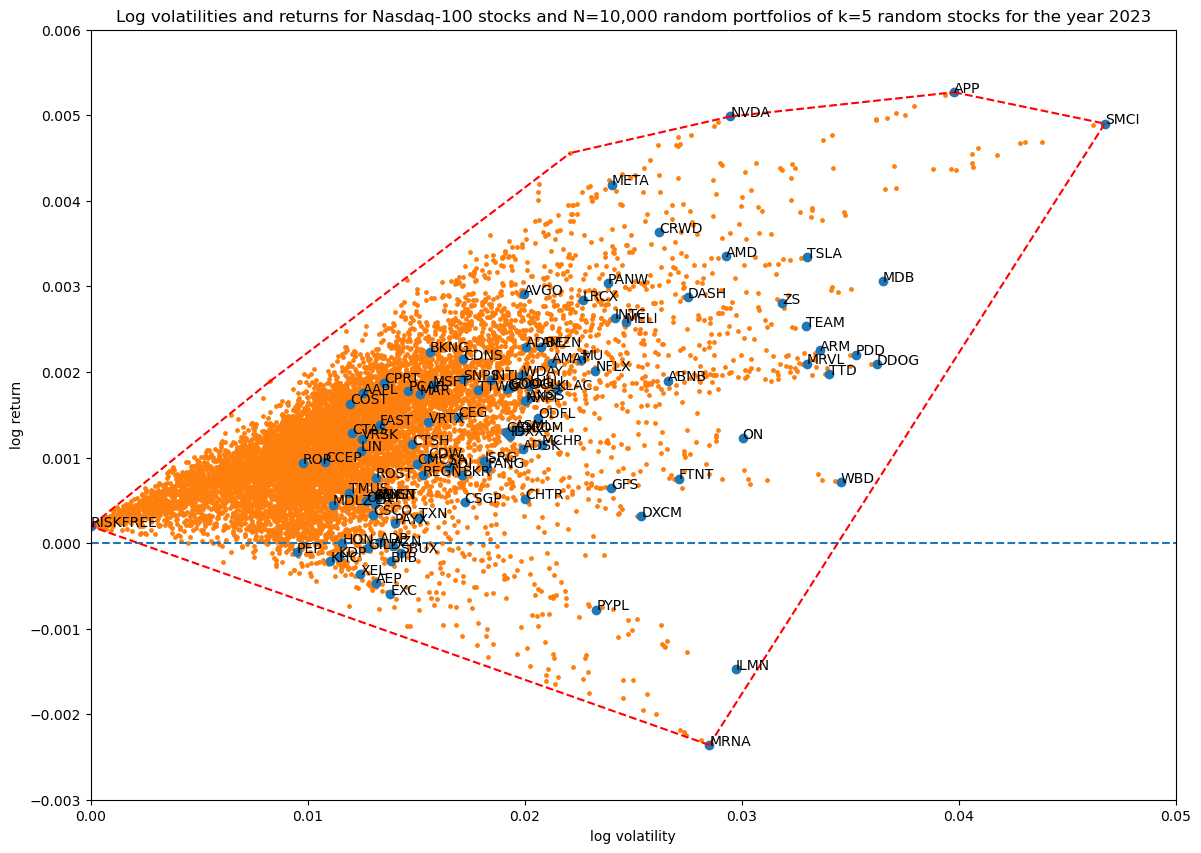

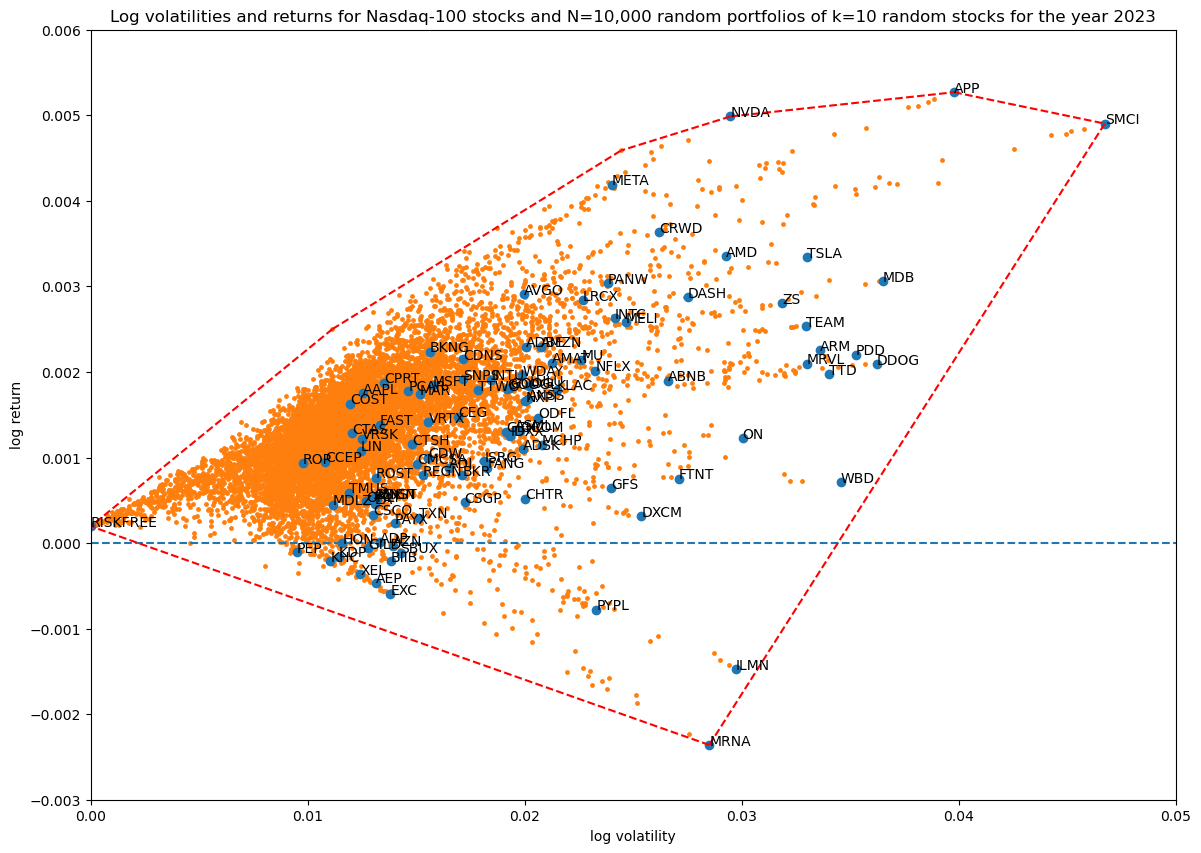

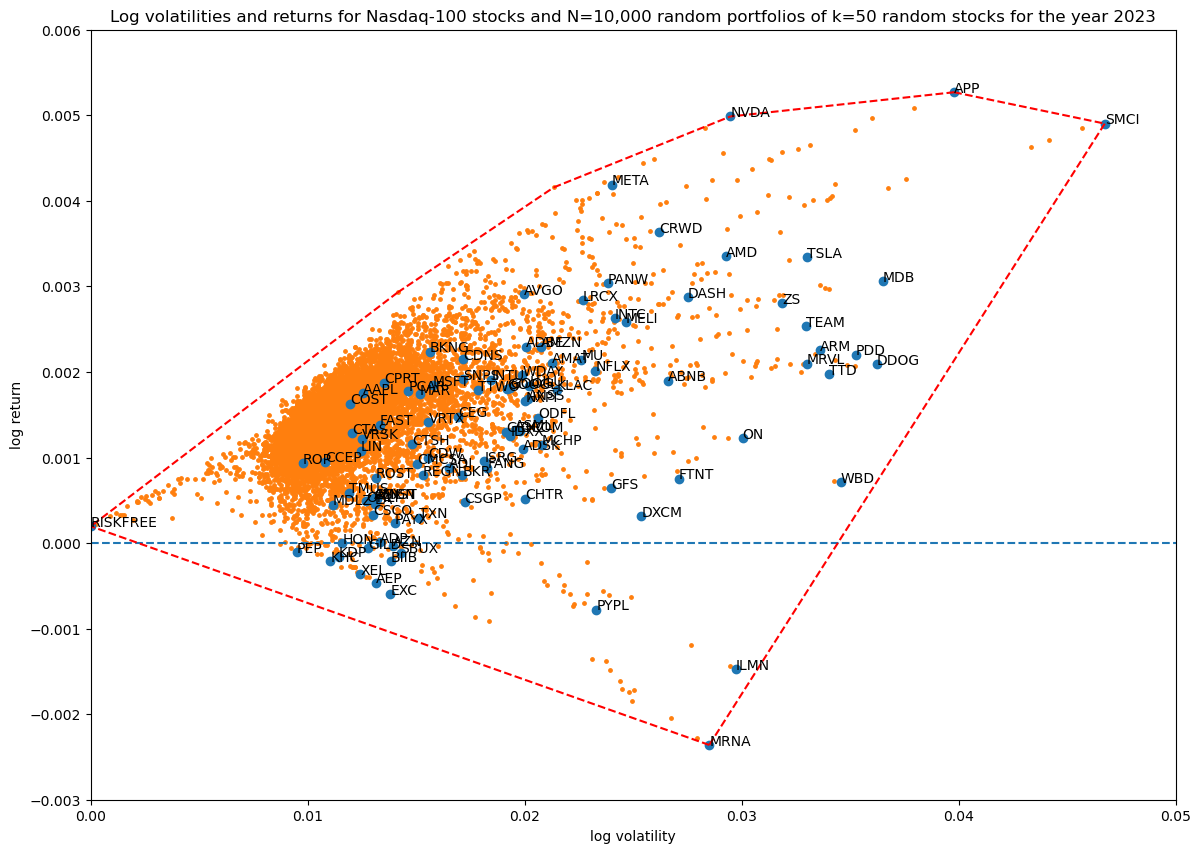

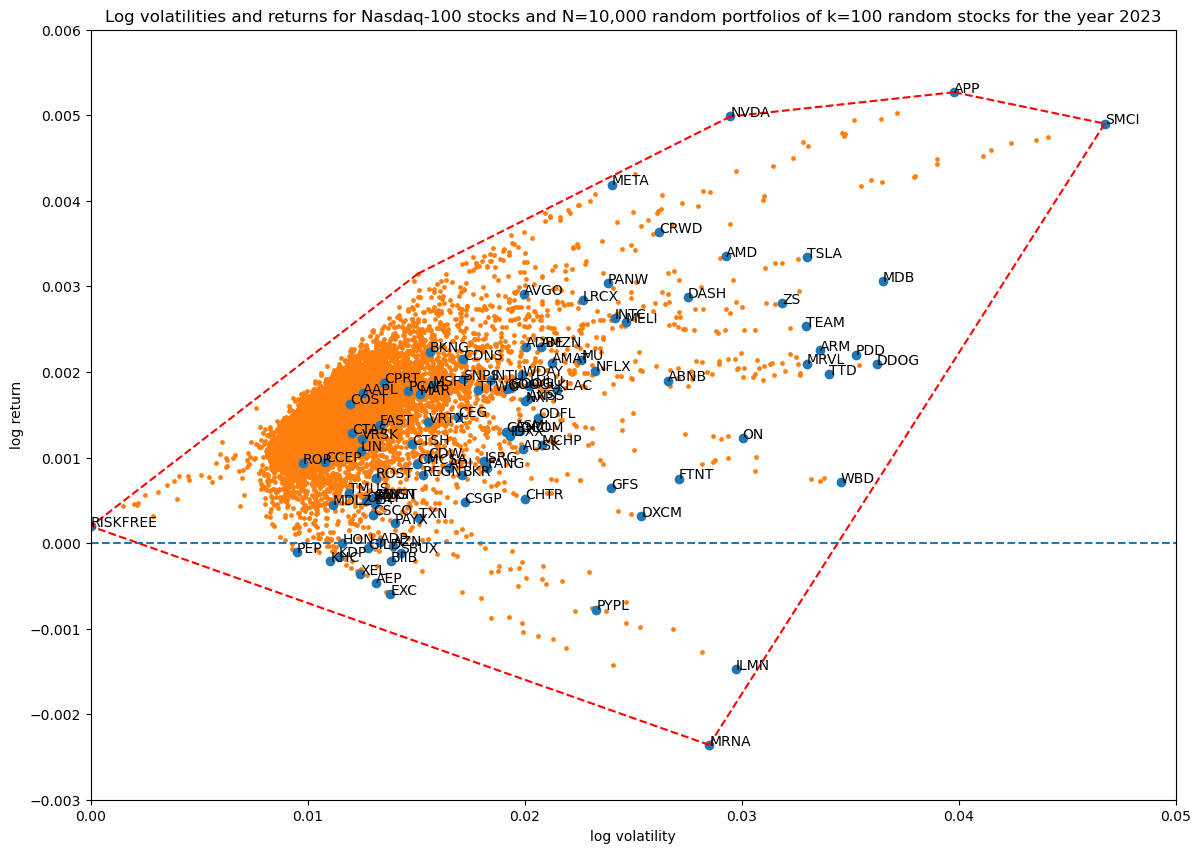

In [16]:
random_portfolio = lambda num_tickers, portfolio_size: random_portfolio_implementation(num_tickers, portfolio_size, fix_last=True)
unit_random = unit_random_angle_projection
num_simulations = 10_000
for portfolio_size in [2, 3, 5, 10, 50, 100]:
    title = f'Log volatilities and returns for Nasdaq-100 stocks and N={num_simulations:,} random portfolios of k={portfolio_size} random stocks for the year 2023'
    portfolios = simulate_portfolios(df_r, portfolio_size, num_simulations)
    hulls[portfolio_size][num_simulations] = plot_portfolios(bare, portfolios, title)

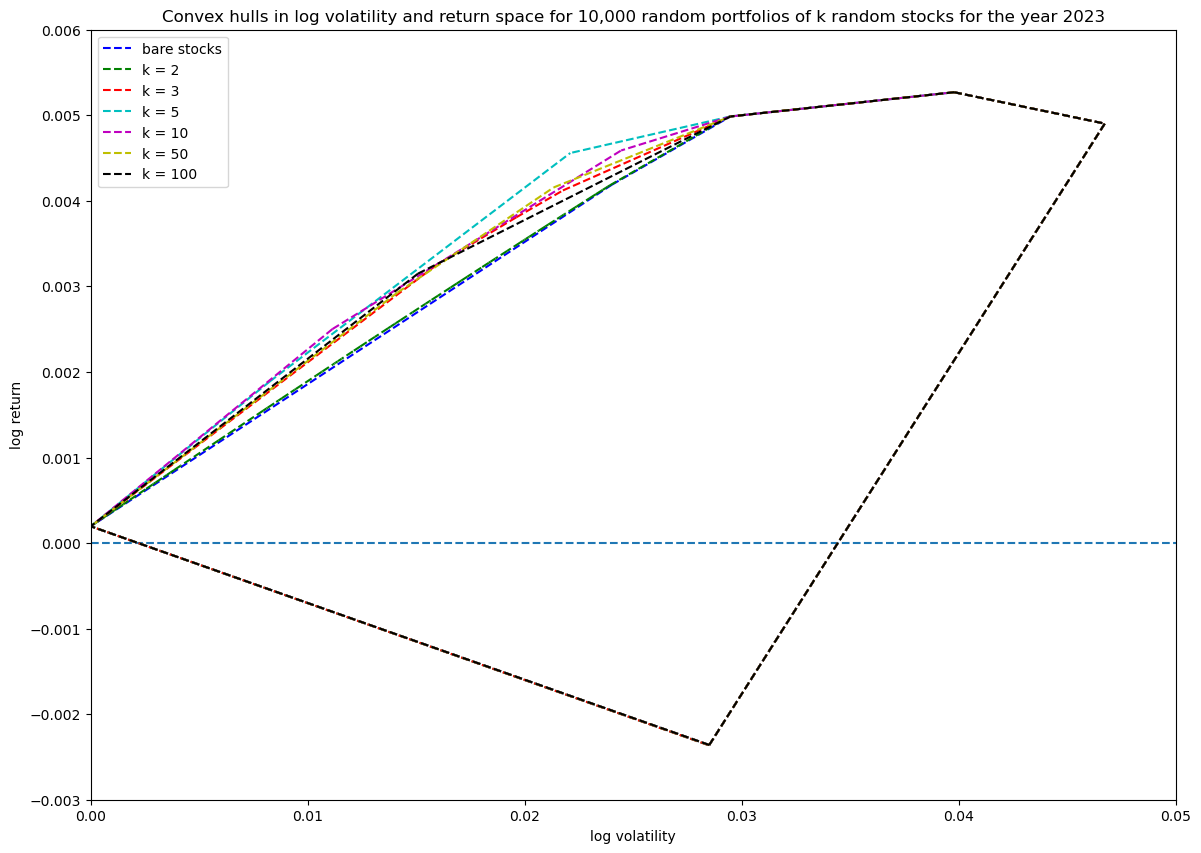

In [18]:
# make list of hulls
ks = [2, 3, 5, 10, 50, 100]
N = 10_000
hs = [hull_bare] + [hulls[k][N] for k in ks]
legends = ['bare stocks'] + [f'k = {k:,}' for k in ks]
# set up plot
fig, ax = plt.subplots(figsize=(14, 10))
ax.axhline(0, linestyle='--')
plt.xlabel('log volatility')
plt.ylabel('log return')
plt.title(f'Convex hulls in log volatility and return space for {N:,} random portfolios of k random stocks for the year 2023')
plt.xlim((0, 0.05))
plt.ylim((-0.003, 0.006))
# plot hulls
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for i, hull in enumerate(hs):
    hxs, hys = hull
    for k, (x, y) in enumerate(zip(hxs, hys)):
        plt.plot(x, y, f'{colors[i]}--', label=legends[i] if k == 0 else None)
plt.legend()

In [19]:
risk_free_annual_return**(1/len(df_logr))

1.00019596363278

In [20]:
np.log(risk_free_annual_return**(1/len(df_logr)))

0.0001959444344153545